# Logistic regression

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random

import pickle

import seaborn as sns
plt.style.use('fivethirtyeight')


In [62]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [63]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score #ordinary linear regression + w/ ridge regularization
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [64]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [65]:
df = pd.read_pickle('data/users_train.pkl')

**View the data**

In [66]:
#dest_bookings = Xtrain.groupby(['country_destination'])['id'].count().reset_index()
#dest_bookings = dest_bookings[dest_bookings['country_destination'] != 'NDF']
#dest_bookings['pct_of_total'] = [(x/dest_bookings['id'].sum())*100 for x in dest_bookings['id']]
#dest_bookings = dest_bookings.sort_values(by='pct_of_total', ascending = False)
#dest_bookings

In [67]:
dest_bookings = df.groupby(['country_destination'])['id'].count().reset_index()
dest_bookings = dest_bookings[dest_bookings['country_destination'] != 'NDF']
dest_bookings['pct_of_total'] = [(x/dest_bookings['id'].sum())*100 for x in dest_bookings['id']]
dest_bookings = dest_bookings.sort_values(by='pct_of_total', ascending = False)
dest_bookings

,country_destination,id,pct_of_total
10,US,62376,70.157916
11,other,10094,11.353309
4,FR,5023,5.649660
6,IT,2835,3.188689
5,GB,2324,2.613938
3,ES,2249,2.529581
1,CA,1428,1.606155
2,DE,1061,1.193368
8,NL,762,0.857066
0,AU,539,0.606245


**Create two target classes (USA/Canada vs. rest of world)**

In [68]:
dest_bookings.country_destination.unique()

array(['US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU',
       'PT'], dtype=object)

In [69]:
dest_dict = {'US': 'USA', 'other':'WLD', 'FR':'WLD', 'IT':'WLD', 
             'GB':'WLD', 'ES':'WLD', 'CA':'USA', 'DE':'WLD', 'NL':'WLD', 'AU':'WLD','PT':'WLD'}
dest_bi = {'USA':0, 'WLD':1}

In [70]:
df['country_USA_World'] = df['country_destination'].map(dest_dict)
df['country_USA_World_bi'] = df['country_USA_World'].map(dest_bi)

In [71]:
df['country_USA_World_bi'].value_counts()/df['country_USA_World_bi'].value_counts().sum()

0.0    0.717641
1.0    0.282359
Name: country_USA_World_bi, dtype: float64

**Define X features and y target**

In [72]:
#df.columns

In [73]:
df.head(1)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app_2_ios,signup_app_2_moweb,secs_elapsed_mean,secs_elapsed_std,num_different_devices,num_different_actions,num_sessions,first_action_type,country_USA_World,country_USA_World_bi
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,unknown,NaN,facebook,0.0,en,direct,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
#df.dtypes

In [75]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
Xy = df[df['country_destination'] != 'NDF']
Xy = Xy.select_dtypes(include=numerics)


In [76]:
len(Xy)

88908

In [77]:
Xy.columns[1:]

Index(['signup_flow', 'gender_female', 'gender_male', 'gender_other',
       'signup_method_basic', 'signup_method_facebook', 'language_ca',
       'language_cs', 'language_da', 'language_de', 'language_el',
       'language_en', 'language_es', 'language_fi', 'language_fr',
       'language_hr', 'language_hu', 'language_id', 'language_is',
       'language_it', 'language_ja', 'language_ko', 'language_nl',
       'language_no', 'language_pl', 'language_pt', 'language_ru',
       'language_sv', 'language_th', 'language_tr', 'country_dest_id',
       'year_created', 'month_created', 'day_created', 'year_active',
       'month_active', 'day_active', 'year_first_booking',
       'month_first_booking', 'day_first_booking', 'lag_book_create',
       'lag_active_create', 'affiliate_channel_2_brand',
       'affiliate_channel_2_direct', 'affiliate_provider_2_direct',
       'affiliate_provider_2_google', 'first_affiliate_tracked_2_linked',
       'first_affiliate_tracked_2_omg', 'first_affiliat

*Date and lag first booking not able to use for prediction*

In [78]:
Xy = Xy.drop(['year_first_booking','month_first_booking', 
              'day_first_booking', 'lag_book_create'], axis = 1)

In [79]:
#X = X.apply(lambda x: x.fillna(x.mean()),axis=0)
nan_rows = Xy[Xy.isnull().any(1)]
len(nan_rows)/len(Xy)

0.7596841679039007

In [80]:
print(len(Xy) - len(nan_rows))

21366


In [81]:
Xy = Xy.dropna(axis='index', how = 'any')

In [82]:
len(Xy)

21366

In [95]:
Xy.describe()

,age,signup_flow,gender_female,gender_male,gender_other,signup_method_basic,signup_method_facebook,language_ca,language_cs,language_da,...,first_browser_2_other,signup_app_2_android,signup_app_2_ios,signup_app_2_moweb,secs_elapsed_mean,secs_elapsed_std,num_different_devices,num_different_actions,num_sessions,country_USA_World_bi
count,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.0,21366.0,21366.000000,...,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000,21366.000000
mean,34.985070,2.879481,0.392680,0.347983,0.001872,0.720584,0.275859,0.0,0.0,0.000094,...,0.191987,0.028644,0.083263,0.019845,27959.947576,80440.038933,1.335112,15.803005,79.528690,0.254470
std,11.027706,7.609049,0.488358,0.476342,0.043229,0.448723,0.446956,0.0,0.0,0.009675,...,0.393872,0.166807,0.276286,0.139469,23290.704425,64484.377775,0.574055,8.322760,81.857238,0.435573
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,12940.882327,31895.030971,1.000000,10.000000,25.000000,0.000000
50%,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,21505.000000,63010.086238,1.000000,14.000000,52.000000,0.000000
75%,39.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,34956.178846,111723.601216,2.000000,20.000000,103.000000,1.000000
max,85.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,190000.000000,313371.525965,6.000000,44.000000,472.000000,1.000000


In [84]:
for col in ['secs_elapsed_mean','secs_elapsed_std','num_different_actions','num_sessions']:
    Xy.loc[np.abs(Xy[col] - Xy[col].mean()) > 3*Xy[col].std()] = np.nan
Xy = Xy.apply(lambda x: x.fillna(x.median()),axis=0)

In [85]:
Xy.to_pickle('data_for_regression_20k.pkl')

***

In [86]:
Xy = pd.read_pickle('data_for_regression_20k.pkl')

In [87]:
y_bi = Xy['country_USA_World_bi']
y_mlt = Xy['country_dest_id']   
X = Xy.drop(['country_dest_id','country_USA_World_bi'], axis = 1)

In [88]:
#X = X.apply(lambda x: x.fillna(x.mean()),axis=0)
nan_rows = X[X.isnull().any(1)]
len(nan_rows)/len(X)

0.0

In [89]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_bi, test_size=0.2, stratify=y_bi,random_state = 88)


In [90]:
print('X',len(X),'Xtrain', len(Xtrain), int((len(Xtrain)/len(X))*100), 
      'Xtest', len(Xtest), int((len(Xtest)/len(X))*100))

X 21366 Xtrain 17092 79 Xtest 4274 20


## 1. Logistic Regression

Steps:  
a. Scale Xtrain/Xtest  
b. Gridsearch CV best parameters (C and penalty) using LogisticRegression class balancing option
c. Explore important features    
d. Save gridsearchcv model to pickle  
e. Test other class balancing methods using optimal C/penalty  
f. Play with different probability thresholds for classification

In [91]:
def get_metrics(m):
    y_predict = m.predict(X_test_scaled)
    print("Model name:",m)
    print("Default threshold:")
    print("Score: {:6.4f}, Precision: {:6.4f}, Recall: {:6.4f}, F1: {:6.4f}".format(m.score(X_test_scaled, ytest),
                                                                                    precision_score(ytest, y_predict), 
                                                                                    recall_score(ytest, y_predict),
                                                                                    f1_score(ytest, y_predict)))

### *a. Scale Xtrain and Xtest*

In [92]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)


### *b. Gridsearch CV best parameters*

In [99]:
print(len(Xtrain), len(X_train_scaled))

17092 17092


*Try to run again to get best recall score*

In [96]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=0, class_weight='balanced')

logreg_cv=GridSearchCV(logreg,grid,cv=5,scoring='recall')
logreg_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
accuracy : 0.6058862493272321


### *c. Define, fit, score model with best parameters*

*How it performs on the cross-validations on average*

In [103]:
#print(logreg_cv.cv_results_)
print("accuracy :",logreg_cv.best_score_)
# ^^^ I think this is the best average score for the best_params averaged across all k-folds 

accuracy : 0.6058862493272321


*How it performs on the test set*

In [104]:
get_metrics(logreg_cv)

Model name: GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)
Default threshold:
Score: 0.5928, Precision: 0.2888, Recall: 0.5928, F1: 0.3884


In [105]:
y_pred_cv = logreg_cv.predict(X_test_scaled)
print(recall_score(ytest, y_pred_cv))

0.5928308823529411


*Define a new model based on best_params to be used on other balance class training data below*  

In [106]:
model = LogisticRegression(C = 0.01, penalty = 'l1', random_state=0, class_weight='balanced')
logreg_cv_best = model.fit(X_train_scaled, ytrain)
logreg_cv_best.score(X_test_scaled, ytest)
get_metrics(logreg_cv_best)

Model name: LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5248, Precision: 0.2888, Recall: 0.5928, F1: 0.3884


In [107]:
logreg_cv_best

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### *d. Save to pickle*

In [108]:
# THE GRIDSEARCH RESULTS #
pkl_filename = 'models/logreg_gridsearch_cv_20k.pkl'
# Open
gridcv_pkl = open(pkl_filename, 'wb')
# Insert object
pickle.dump(logreg_cv, gridcv_pkl)
# Close
gridcv_pkl.close()

# THE MODEL WITH BEST PARAMS FIT ON SCALED TRAIN DATA #
pkl_filename_2 = 'models/logreg_cv_20k.pkl'
# Open 
model_pkl = open(pkl_filename_2, 'wb')
# Insert object
pickle.dump(logreg_cv_best, model_pkl)
# Close
model_pkl.close()

### *e. Explore important features*

**Import best classifier pickle**

In [109]:
logreg_cv = pd.read_pickle('models/logreg_cv_20k.pkl')
# This was called logreg_cv_best when pickled tho

In [110]:
logreg_cv

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [111]:
coef_dict = {}
for coef, feat in zip(logreg_cv.coef_[0],Xtrain.columns):
    coef_dict[feat] = coef
sorted(coef_dict.items(), key=lambda kv: kv[1], reverse=True)[0:10]

[('gender_male', 0.16997466827276853),
 ('num_sessions', 0.1362791920027659),
 ('gender_female', 0.10643884444663931),
 ('first_device_type_2_mac desktop', 0.10457765009992456),
 ('first_device_type_2_ipad', 0.07569003823225495),
 ('first_browser_2_ie', 0.0613142240349707),
 ('first_browser_2_chrome', 0.04758622405671925),
 ('age', 0.0445272988376546),
 ('first_browser_2_firefox', 0.03307212288271798),
 ('language_it', 0.02818652446922778)]

In [112]:
features = pd.DataFrame([coef_dict]).transpose().reset_index()
features.columns = ['feature','weight']
features['abs_weight'] = abs(features.weight)
features = features.sort_values(by='abs_weight', ascending = False).reset_index(drop=True)
features = features[features.feature != 'month_first_booking']
features[0:10]

,feature,weight,abs_weight
0,gender_male,0.169975,0.169975
1,num_sessions,0.136279,0.136279
2,num_different_actions,-0.113019,0.113019
3,gender_female,0.106439,0.106439
4,first_device_type_2_mac desktop,0.104578,0.104578
5,first_device_type_2_ipad,0.075690,0.075690
6,first_browser_2_ie,0.061314,0.061314
7,first_browser_2_chrome,0.047586,0.047586
8,age,0.044527,0.044527
9,signup_app_2_moweb,-0.041465,0.041465


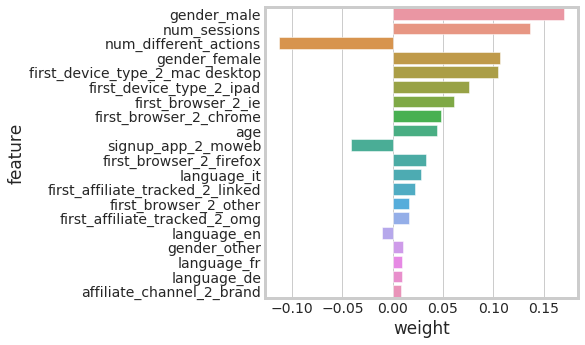

In [113]:
sns.set_style("whitegrid")
ftplot, ax = plt.subplots(figsize = (5,5))
ftplot = sns.barplot(y="feature", x="weight", 
            orient="h", data=features[0:20])
y_lab = ['Google advertisement', 'Number of page visits', 'Marketing OMG', 
         'Used mobile browser', 'Used iPad']
#ax.set_yticklabels(labels=y_lab, ha='right');
axes = ftplot.axes
#axes.set_xlim(-.02,.02);

## *e. Test other class balancing methods using optimal C/penalty* 

In [114]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [115]:
#model_2 = LogisticRegression(C = 0.001, penalty = 'l1', random_state=0)
logreg_cv

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

**Random oversampling**

In [116]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train_scaled,ytrain)
#logit_over_sampled = model_2.fit(X_resampled, y_resampled)
#logit_over_sampled.score(X_test_scaled, ytest)

In [117]:
logit_over_sampled = logreg_cv_best.fit(X_resampled, y_resampled)
get_metrics(logit_over_sampled)

Model name: LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5325, Precision: 0.2919, Recall: 0.5864, F1: 0.3897


**ADASYN**

In [118]:
ada = ADASYN(random_state=42)
X_adasyn, y_adasyn = ada.fit_sample(X_train_scaled,ytrain)

In [119]:
logit_adasyn = logreg_cv_best.fit(X_adasyn, y_adasyn)
logit_adasyn.score(X_test_scaled, ytest)

0.5238652316331306

In [120]:
get_metrics(logit_adasyn)

Model name: LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5239, Precision: 0.2883, Recall: 0.5928, F1: 0.3880


**SMOTE**

In [121]:
smt = SMOTE(random_state=42)
X_smoted, y_smoted = smt.fit_sample(X_train_scaled,ytrain)


In [122]:
logit_smote = logreg_cv_best.fit(X_smoted, y_smoted)
logit_smote.score(X_test_scaled, ytest)

0.5224613944782405

In [123]:
get_metrics(logit_smote)

Model name: LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5225, Precision: 0.2864, Recall: 0.5873, F1: 0.3851


**Undersampling**

In [124]:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_sample(X_train_scaled,ytrain)

In [125]:
logit_undersample = logreg_cv_best.fit(X_under, y_under)
model.score(X_test_scaled, ytest)

0.5163781001403838

In [126]:
get_metrics(logit_undersample)

Model name: LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Default threshold:
Score: 0.5164, Precision: 0.2827, Recall: 0.5855, F1: 0.3813


In [116]:
y_predict = logit_undersample.predict(X_test_scaled)
recall_score(ytest, y_predict)

0.5443294785960641

In [127]:
np.save('models/X_adasyn', X_adasyn)
np.save('models/y_adasyn', y_adasyn)

np.save('models/X_under', X_under)
np.save('models/y_under', y_under)

np.save('models/X_smoted', X_smoted)
np.save('models/y_smoted', y_smoted)

np.save('models/X_resampled', X_resampled)
np.save('models/y_resampled', y_resampled)

**My metric: Recall of class 0**
Precision: Be more sure someone is going to US Before you market
Recall: Catching people going to US

from sklearn.metrics import classification_report
for m in models:
    print()

Next steps: Lower threshold for how you classify Europeans (change to 1)
1. ypredict = m.predict_proba(X_test)[:,1] > 0.6  
2. Run KNN and compare AUCs
3. Random forest + feature importance
4. Plot AUCs for all models
5. Interactive bokeh graph that takes 4 models, range of predict_probas, to choose best model

## Where to go between 0.4 and 0.4??

*Pickling the class balancers really just pickled the logreg_cv model*  
*Need to re-fit on the balanced data sets*

In [144]:
y_predict = logreg_cv.predict_proba(X_test_scaled)[:,1]
y_predict

4274

In [129]:
probs=np.arange(0.,1.05,0.05)

df_probas = pd.DataFrame(y_predict)
df_probas.columns = ['probability']
df_probas = df_probas.assign(ytest=ytest.values)

for p in probs.round(2):    
    df_probas['thrs_'+str(p)] = np.where(df_probas.eval("probability > "+str(p)), 1, 0)
    #df_probas.loc[df_probas['thrs_'+str(p)] == df_probas['ytest'], 'match_'+str(p)] = 1
    #df_probas.loc[df_probas['thrs_'+str(p)] != df_probas['ytest'], 'match_'+str(p)] = 0
#df_probas = pd.concat(df_probas, ytest)
df_probas.shape

(4274, 23)

In [130]:
df_probas = df_probas.reset_index()
df_probas.describe()

,index,probability,ytest,thrs_0.0,thrs_0.05,thrs_0.1,thrs_0.15,thrs_0.2,thrs_0.25,thrs_0.3,...,thrs_0.55,thrs_0.6,thrs_0.65,thrs_0.7,thrs_0.75,thrs_0.8,thrs_0.85,thrs_0.9,thrs_0.95,thrs_1.0
count,4274.000000,4274.000000,4274.000000,4274.0,4274.0,4274.0,4274.0,4274.0,4274.0,4274.0,...,4274.000000,4274.000000,4274.000000,4274.000000,4274.0,4274.0,4274.0,4274.0,4274.0,4274.0
mean,2136.500000,0.498527,0.254562,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.188582,0.035330,0.006083,0.000702,0.0,0.0,0.0,0.0,0.0,0.0
std,1233.941854,0.060196,0.435666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.391222,0.184634,0.077767,0.026488,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.307528,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,1068.250000,0.461587,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,2136.500000,0.503174,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,3204.750000,0.540194,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,4273.000000,0.718321,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
y_predict

array([0.41675612, 0.41536595, 0.518775  , ..., 0.58356692, 0.41027139,
       0.4813508 ])

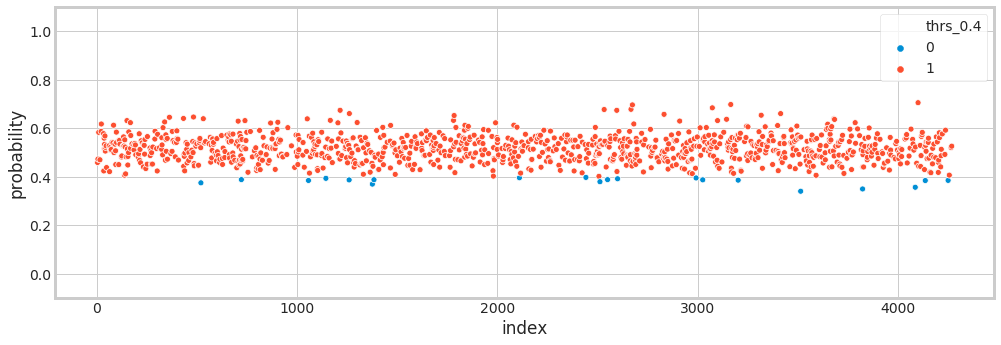

In [142]:
sns.set_style("whitegrid")
ftplot, ax = plt.subplots(figsize = (15,5))
ftplot = sns.scatterplot(y="probability", x='index', 
            data=df_probas[df_probas.ytest == 1], hue = 'thrs_0.4', alpha = 1)

#ax.set_yticklabels(labels=y_lab, ha='right');
axes = ftplot.axes
axes.set_ylim(-0.1,1.1);

In [145]:
pred_probas = {}
probs=np.arange(0.,1.05,0.05)
for p in probs:
    #logit_adasyn = logreg_cv.fit(X_adasyn, y_adasyn)
    y_predict = logreg_cv.predict_proba(X_test_scaled)[:,1] > p
    recall = recall_score(ytest, y_predict)
    pred_probas[p] = recall
    #print(p,recall)
pred_probas

{0.0: 1.0,
 0.05: 1.0,
 0.1: 1.0,
 0.15000000000000002: 1.0,
 0.2: 1.0,
 0.25: 1.0,
 0.30000000000000004: 1.0,
 0.35000000000000003: 0.9981617647058824,
 0.4: 0.9816176470588235,
 0.45: 0.8832720588235294,
 0.5: 0.5928308823529411,
 0.55: 0.24724264705882354,
 0.6000000000000001: 0.05422794117647059,
 0.65: 0.011948529411764705,
 0.7000000000000001: 0.0009191176470588235,
 0.75: 0.0,
 0.8: 0.0,
 0.8500000000000001: 0.0,
 0.9: 0.0,
 0.9500000000000001: 0.0,
 1.0: 0.0}

In [147]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(ytest, logit_adasyn.predict_proba(X_test_scaled)[:,1])

In [148]:
(logit_adasyn.predict_proba(X_test_scaled)[:,1] > 0.4)

array([ True,  True,  True, ...,  True,  True,  True])

ROC AUC score =  0.5855952108950925


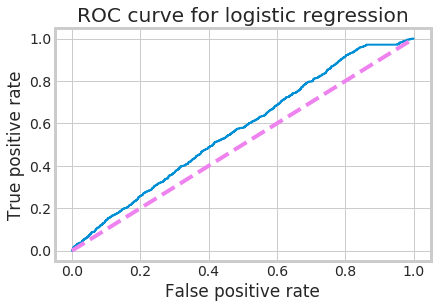

In [149]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for logistic regression');
print("ROC AUC score = ", roc_auc_score(ytest, logreg_cv.predict_proba(X_test_scaled)[:,1]))

***

## 2. KNN